<strong>
    <h1>
Libs para o processamento

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

<strong>
    <h1>
        Coleta de dados

In [3]:
# Load training and testing datasets
train_df = pd.read_csv("Training.csv")
test_df = pd.read_csv("Testing.csv")


# Combine both datasets into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)

# Reset index to ensure it's ordered correctly
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<strong>
    <h1>
        Análise exploratória de dados

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   int64  
 2   BloodPressure             2768 non-null   int64  
 3   SkinThickness             2768 non-null   int64  
 4   Insulin                   2768 non-null   int64  
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 194.8 KB


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2768.0,3.822616,3.305432,0.000,1.000,3.00,6.00000,17.00
Glucose,2768.0,121.421965,31.721258,0.000,100.000,117.00,142.00000,199.00
BloodPressure,2768.0,68.980491,19.133100,0.000,64.000,71.00,80.00000,122.00
SkinThickness,2768.0,20.549494,15.779713,0.000,0.000,23.00,33.00000,99.00
Insulin,2768.0,79.853324,115.655771,0.000,0.000,36.00,129.00000,846.00
BMI,2768.0,31.976590,7.760540,0.000,27.175,32.10,36.50000,67.10
DiabetesPedigreeFunction,2768.0,0.486277,0.357403,0.078,0.248,0.38,0.64525,2.42
Age,2768.0,32.923049,11.362964,21.000,24.000,29.00,40.00000,81.00
Outcome,2768.0,0.380419,0.485578,0.000,0.000,0.00,1.00000,1.00


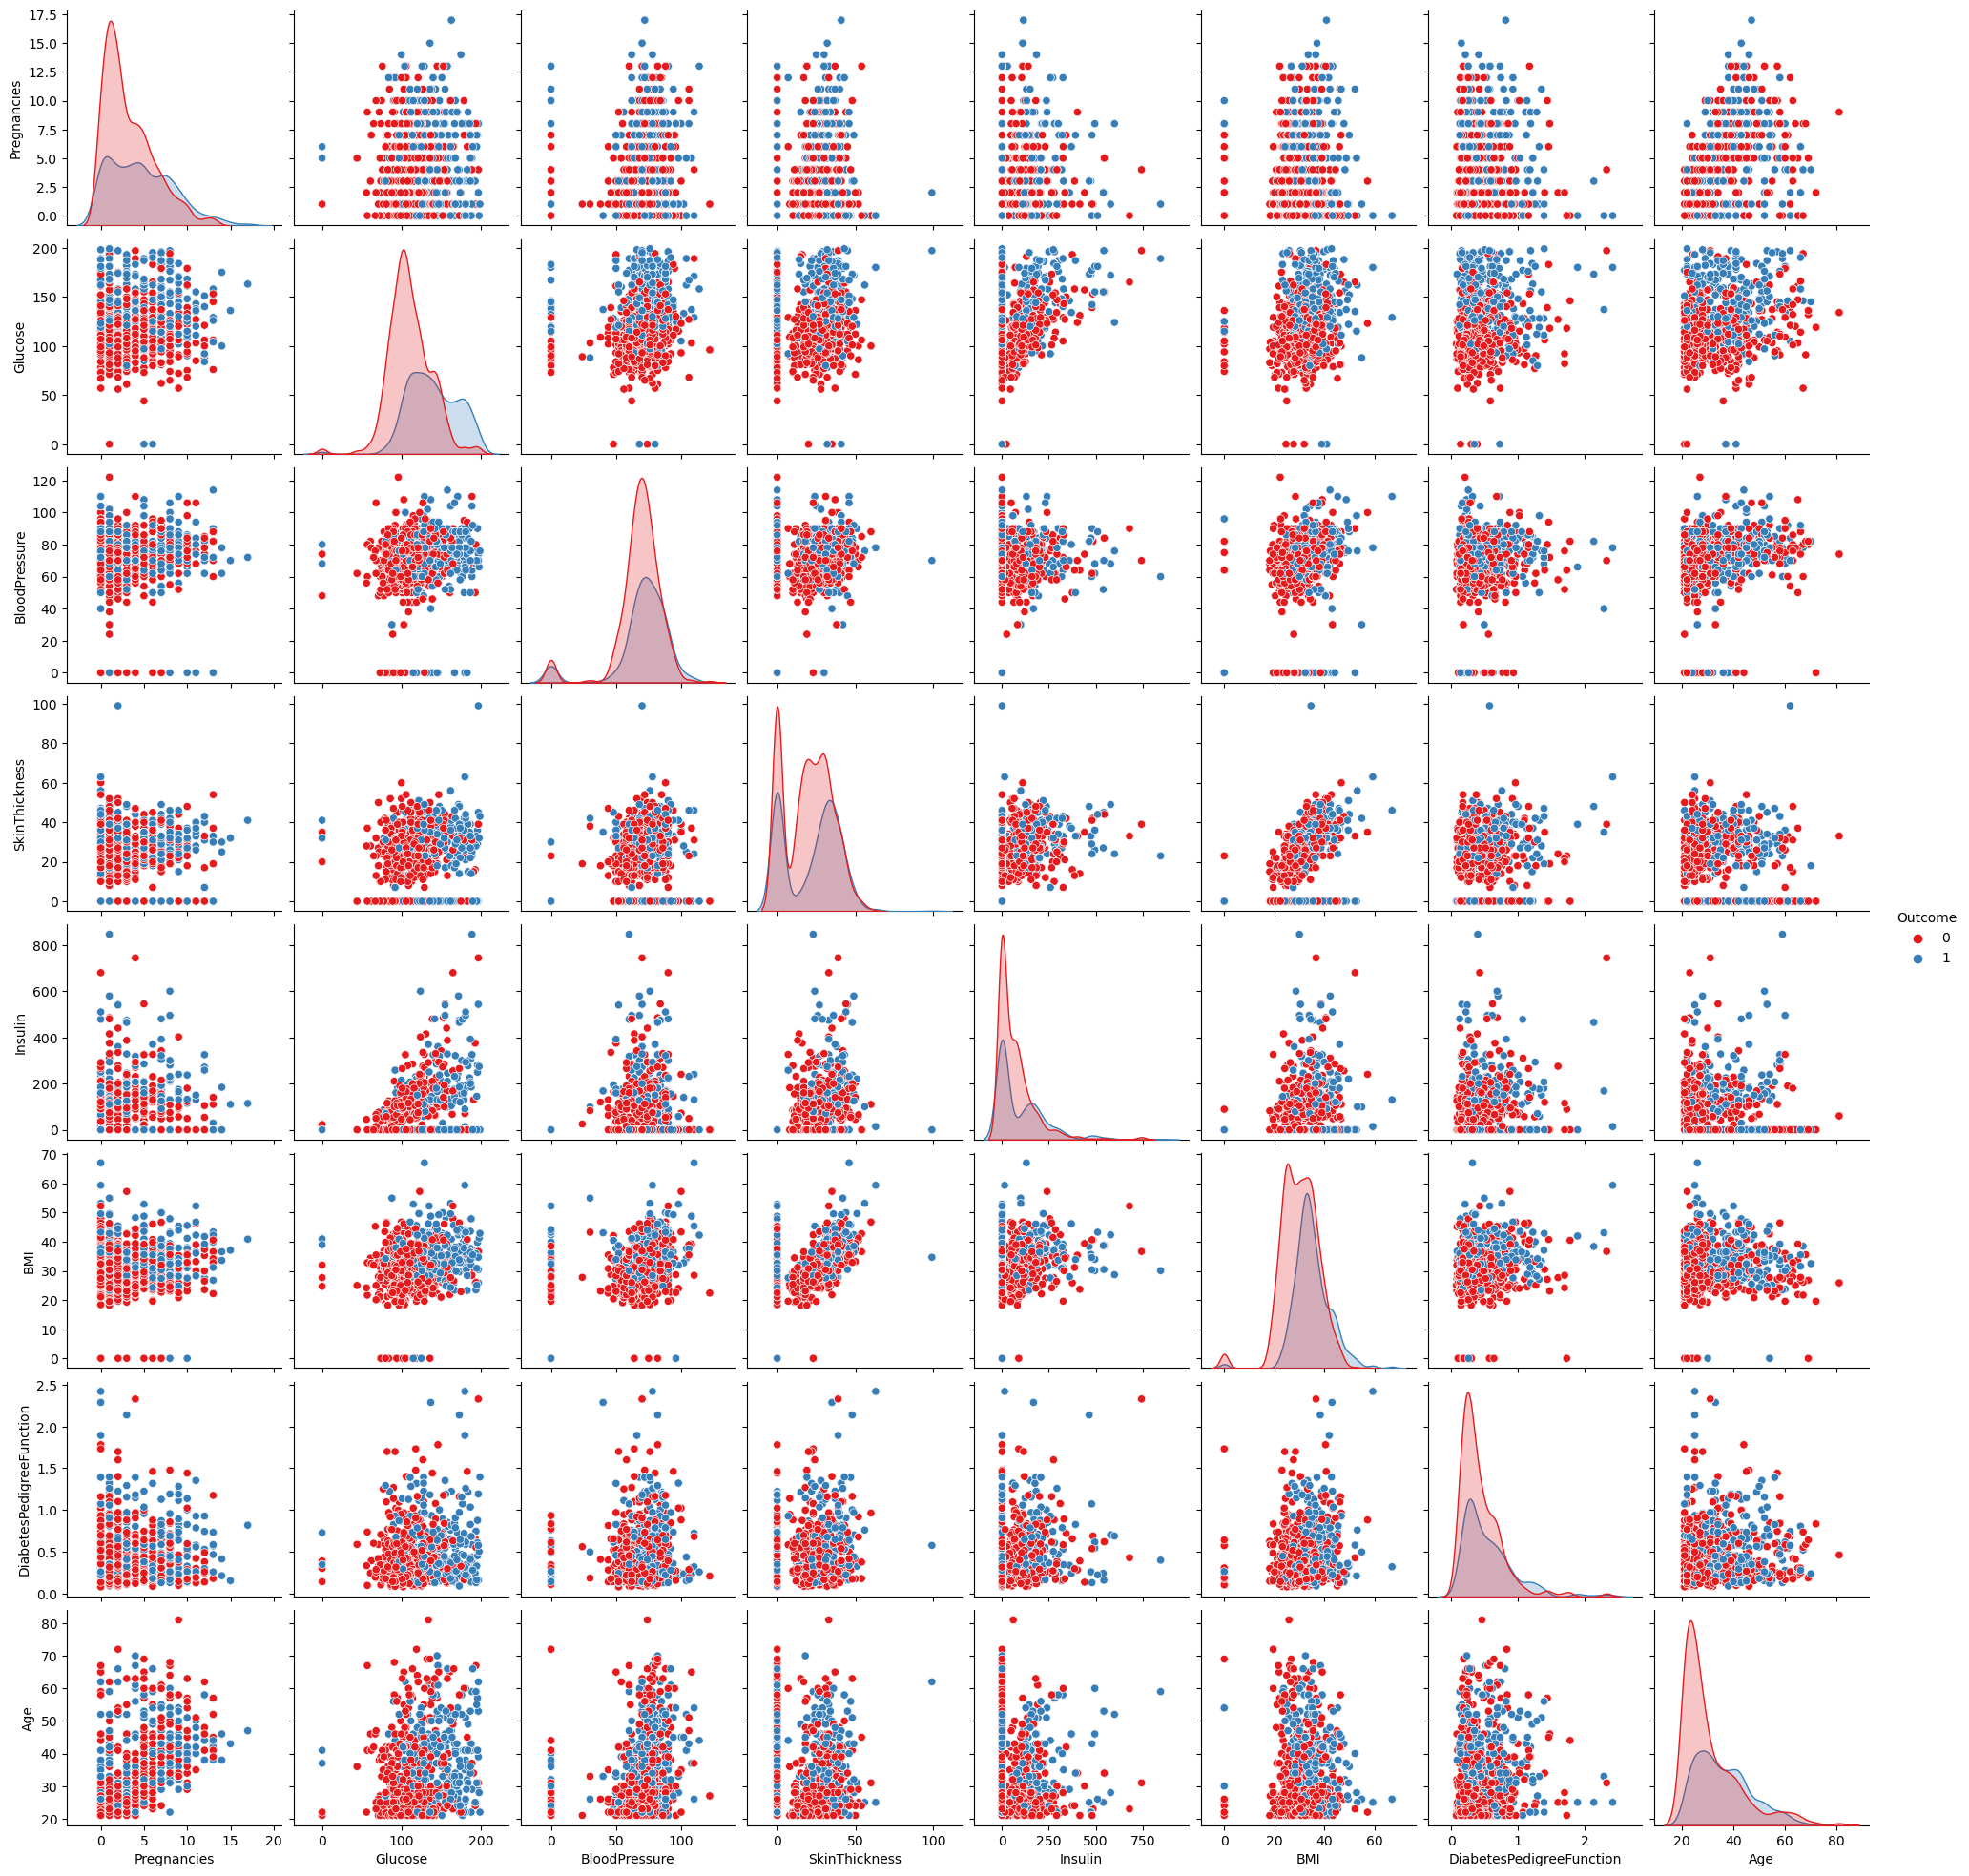

In [5]:
sns.pairplot(df, hue='Outcome',palette ='Set1');

In [6]:
numerical_columns = df.drop(columns=['Outcome']).columns
df_numerical = df[numerical_columns]

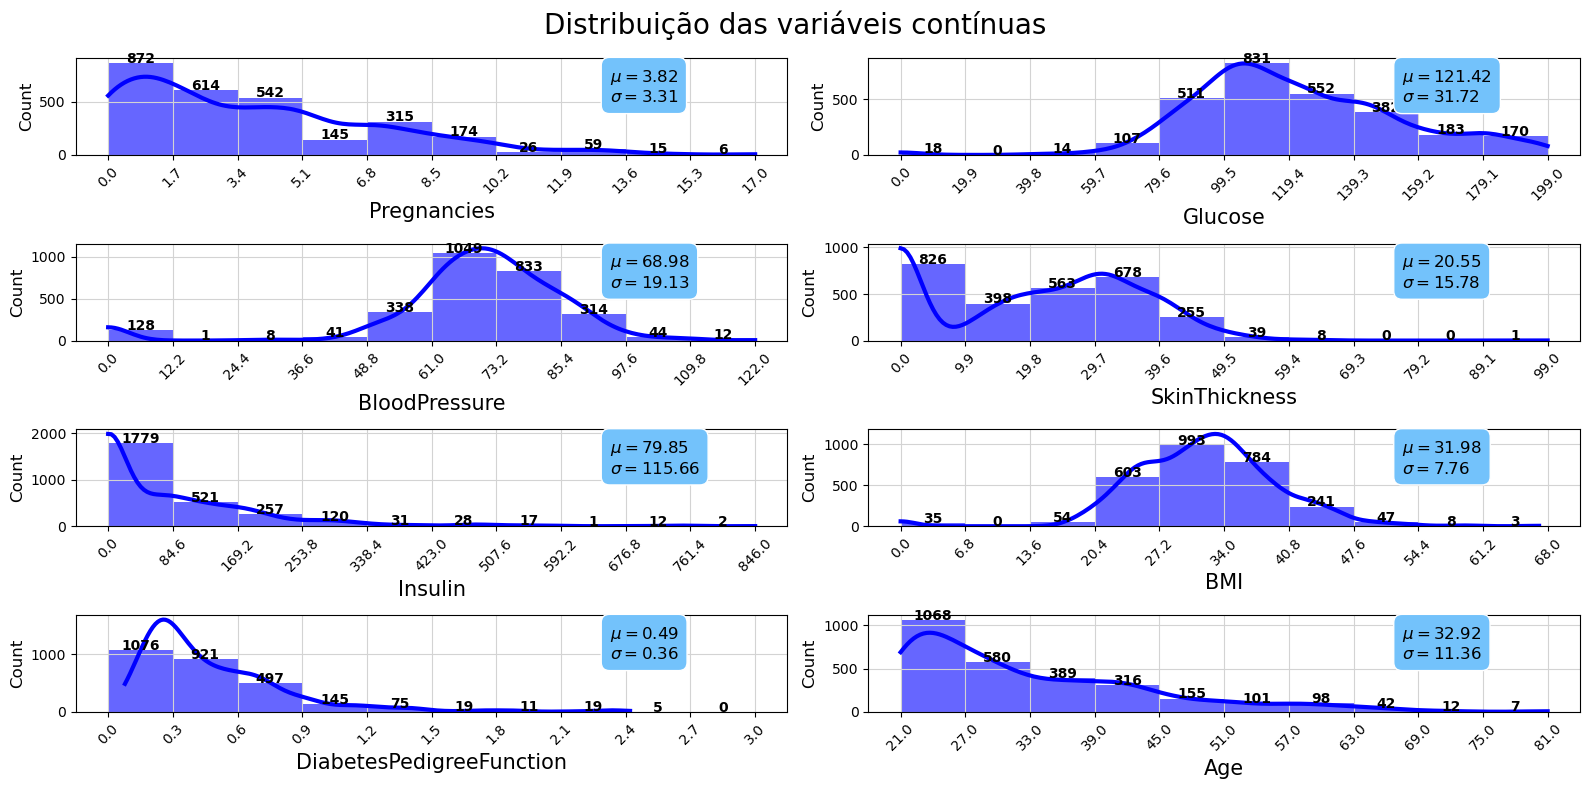

In [27]:
# Set up the subplot
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 8))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_numerical.columns):
    x = i // 2
    y = i % 2
    values, bin_edges = np.histogram(df_numerical[col], 
                                     range=(np.floor(df[col].min()), np.ceil(df_numerical[col].max())))
    
    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='blue', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_numerical[col].mean(),
        r'$\sigma=%.2f$' % df_numerical[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='black', bbox=dict(boxstyle='round', facecolor='#73c2fb', edgecolor='white', pad=0.5))


plt.suptitle('Distribuição das variáveis contínuas', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

<strong>
<h1>
Feature Engineering

In [8]:
# Valores Nulos

In [9]:
df.isnull().sum().sum()

0

In [10]:
#Análise de Outlier

In [11]:
numerical_columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [12]:
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

Pregnancies                  21
Glucose                      18
BloodPressure               161
SkinThickness                 1
Insulin                     109
BMI                          61
DiabetesPedigreeFunction    111
Age                          47
dtype: int64

In [13]:
#Check Imbalanced Data

In [14]:
df['Outcome'].value_counts()

Outcome
0    1715
1    1053
Name: count, dtype: int64

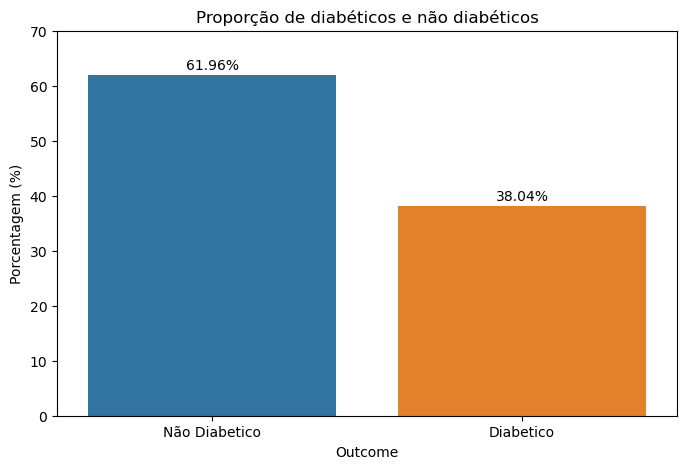

In [15]:
# Calculating the percentage of each class
percentage = df['Outcome'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage )
plt.title('Proporção de diabéticos e não diabéticos')
plt.xlabel('Outcome')
plt.ylabel('Porcentagem (%)')
plt.xticks(ticks=[0, 1], labels=['Não Diabetico', 'Diabetico'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

<strong>
    <h1>
        Aplicar modelo de ML

<strong>
    <h2>
        Usando Redes Neurais Artificiais

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay

# Dividindo os dados em características e rótulos
X = df.drop('Outcome', axis=1)  # Características
y = df['Outcome']  # Rótulos

# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificando variáveis contínuas e categóricas
variaveis_continuas = X_train.select_dtypes(include=['int64', 'float64']).columns
variaveis_categoricas = X_train.select_dtypes(include=['object']).columns

# Pipeline para pré-processamento das características
transformer_pipeline = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), variaveis_continuas),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), variaveis_categoricas)
])

# Aplicando o pré-processamento nos dados de treinamento
X_train_preprocessed = transformer_pipeline.fit_transform(X_train)

# Balanceamento de dados usando resample
X_train_balanced, y_train_balanced = resample(X_train_preprocessed[y_train == 1], 
                                              y_train[y_train == 1], 
                                              replace=True,
                                              n_samples=X_train_preprocessed[y_train == 0].shape[0],
                                              random_state=42)

X_train_preprocessed_balanced = np.vstack((X_train_preprocessed[y_train == 0], X_train_balanced))
y_train_balanced = np.hstack((y_train[y_train == 0], y_train_balanced))

# Definindo os parâmetros que gostaríamos de otimizar
param_grid = {
    'hidden_layer_sizes': [(50,), (7, 7, 7), (100,), (50, 50), (100, 50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

#'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],

# Criando o modelo MLP
mlp_classifier = MLPClassifier(random_state=42)

# Criando o objeto GridSearchCV
grid_search = GridSearchCV(mlp_classifier, param_grid, cv=5, scoring='accuracy')

# Treinando o modelo
grid_search.fit(X_train_preprocessed_balanced, y_train_balanced)

# Extraindo os melhores parâmetros
best_params = grid_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avaliando o desempenho do modelo com os melhores parâmetros
best_model = grid_search.best_estimator_
X_test_preprocessed = transformer_pipeline.transform(X_test)
y_pred = best_model.predict(X_test_preprocessed)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


Melhores parâmetros encontrados: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       343
           1       0.96      0.95      0.95       211

    accuracy                           0.97       554
   macro avg       0.96      0.96      0.96       554
weighted avg       0.97      0.97      0.97       554

Matriz de Confusão:
[[335   8]
 [ 11 200]]


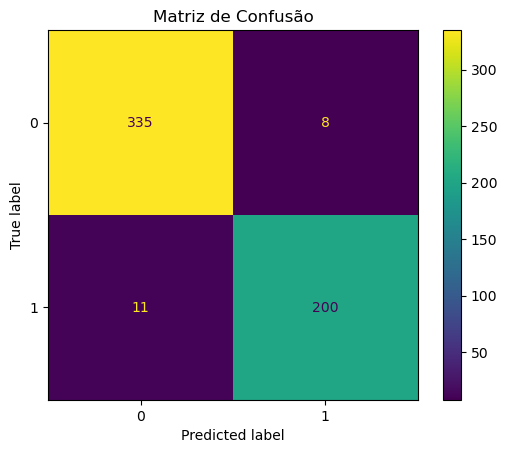

In [17]:
cm = confusion_matrix(y_test, y_pred)

# Plotando a matriz de confusão
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
cm_display.plot()
plt.title('Matriz de Confusão')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


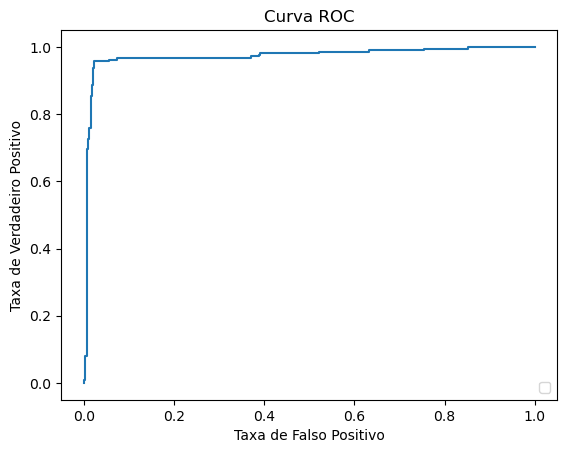

In [18]:
# Obtendo as probabilidades previstas pelo modelo
y_probs = best_model.predict_proba(X_test_preprocessed)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plotando a curva ROC
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('Curva ROC')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.show()

In [19]:
from sklearn import set_config

In [20]:
set_config(display='diagram')
transformer_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index([], dtype='object'))])

In [21]:
set_config(display='diagram')
grid_search

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (7, 7, 7), (100,),
                                                (50, 50), (100, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [22]:
set_config(display='diagram')
best_model

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50), random_state=42)

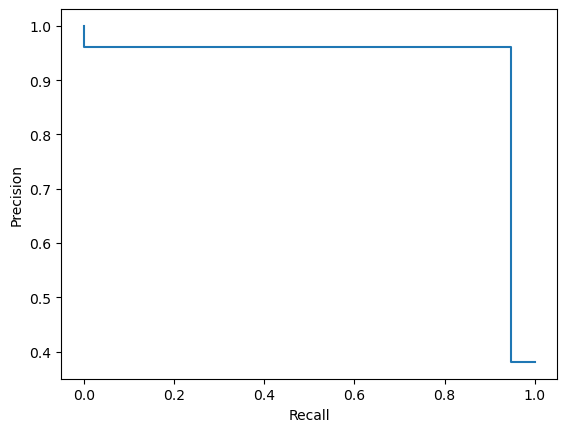

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()